## POOL uSTONKS_APR21_USDC

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 78

X_NAME = 'uSTONKS_APR21'
Y_NAME = 'USDC'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,13,USDC,uSTONKS_APR21,2159.220526,0.0,9.930202,8.636882,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37571.0,2021-03-09 15:01:34,2021-03-09 15:01:21,0xeaf57e2488fdd6b12b0d01ba29f687f2523efe2f1126...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9670d11c6bdde4d239f699ac71dd77075c35603d,13,1689.373119,361525.849725,6.107521e+08,0,0,False,1679.442917,363676.433369,6.107738e+08,0,0,False,216.545873,0.011897
1,15,USDC,uSTONKS_APR21,909.722591,0.0,4.149160,3.638890,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37578.0,2021-03-09 15:03:19,2021-03-09 15:03:07,0xdaa555d301b25d8dec1d814a1edf263b25ecf703c00e...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x64e78ba4baca646f77a6bf7bcbcc5a31fc066ef2,15,1746.442916,378185.954470,6.604802e+08,0,0,False,1742.293756,379092.038171,6.604897e+08,22737,0,False,217.582160,0.004783
2,32,USDC,uSTONKS_APR21,8881.277097,0.0,39.726505,35.525108,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37729.0,2021-03-09 15:41:04,2021-03-09 15:41:02,0x749f55e09dfd5ec051ad880919f44c9816b708718d18...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd2a78bb82389d30075144d17e782964918999f7f,32,2352.373651,511846.369144,1.204054e+09,22737,0,False,2312.647146,520692.121132,1.204177e+09,515572,10,False,225.149834,0.034757
3,40,USDC,uSTONKS_APR21,225.978716,0.0,0.993224,0.903915,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37846.0,2021-03-09 16:10:19,2021-03-09 16:10:17,0xbec0e4637d4a85ecbae54044c8b49a26929eca1a91d4...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf3239400cd2135cf5f99e191018eeb2a6d01eb76,40,2396.647138,539609.488580,1.293254e+09,515572,10,False,2395.653914,539834.563381,1.293257e+09,910713,18,False,225.339128,0.000832
4,45,USDC,uSTONKS_APR21,452.519620,0.0,1.986456,1.810078,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,38016.0,2021-03-09 16:52:49,2021-03-09 16:52:44,0xadf350a8ae7c9576db9f875e88081856085159359245...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9ebc8ad4011c7f559743eb25705ccf5a9b58d0bc,45,2427.201400,546945.213761,1.327546e+09,910713,18,False,2425.214943,547395.923303,1.327553e+09,1485330,30,False,225.710271,0.001644


In [9]:
swaps0_df.status.value_counts()

SUCCESS    174
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS    174
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                166
CANT_CONSULT_ORACLE      8
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.04597701149425287


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    134
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    134
Name: status, dtype: int64


**0** have been **blocked by the volatility mitigation mechanism**. In only 4% of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (94% without modification)

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

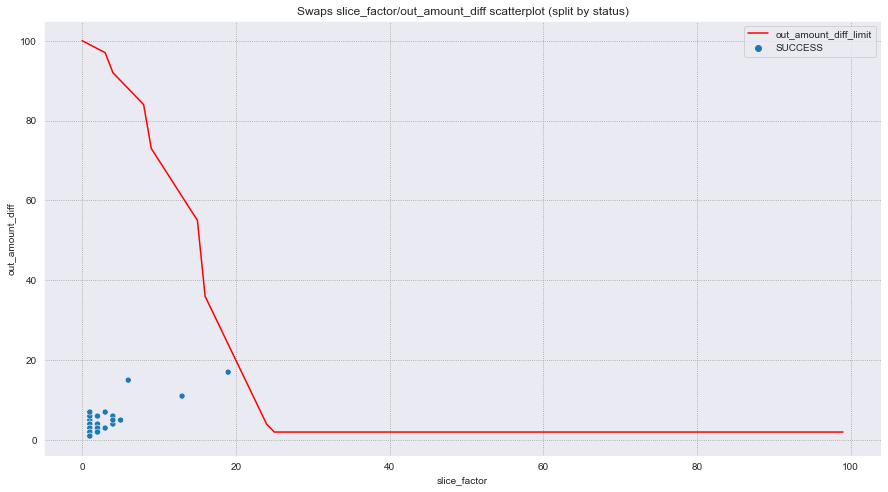

In [50]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be seen that there are more observations than in the initial version, as the volatility mitigation checked much more transactions because of the TWAP availability.**

In [51]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,13,USDC,uSTONKS_APR21,2159.220526,0.0,9.930202,8.636882,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37571.0,2021-03-09 15:01:34,2021-03-09 15:01:21,0xeaf57e2488fdd6b12b0d01ba29f687f2523efe2f1126...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9670d11c6bdde4d239f699ac71dd77075c35603d,13,1689.373119,3.615258e+05,6.107521e+08,0,0,False,1679.442917,3.636764e+05,6.107738e+08,0,0,False,216.545873,0.011897
1,15,USDC,uSTONKS_APR21,909.722591,0.0,4.149160,3.638890,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37578.0,2021-03-09 15:03:19,2021-03-09 15:03:07,0xdaa555d301b25d8dec1d814a1edf263b25ecf703c00e...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x64e78ba4baca646f77a6bf7bcbcc5a31fc066ef2,15,1746.442916,3.781860e+05,6.604802e+08,0,0,False,1742.293756,3.790920e+05,6.604897e+08,22737,0,False,217.582160,0.004783
2,32,USDC,uSTONKS_APR21,8881.277097,0.0,39.726505,35.525108,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37729.0,2021-03-09 15:41:04,2021-03-09 15:41:02,0x749f55e09dfd5ec051ad880919f44c9816b708718d18...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd2a78bb82389d30075144d17e782964918999f7f,32,2352.373651,5.118464e+05,1.204054e+09,22737,0,False,2312.647146,5.206921e+05,1.204177e+09,515572,10,False,225.149834,0.034757
3,40,USDC,uSTONKS_APR21,225.978716,0.0,0.993224,0.903915,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,37846.0,2021-03-09 16:10:19,2021-03-09 16:10:17,0xbec0e4637d4a85ecbae54044c8b49a26929eca1a91d4...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf3239400cd2135cf5f99e191018eeb2a6d01eb76,40,2396.647138,5.396095e+05,1.293254e+09,515572,10,False,2395.653914,5.398346e+05,1.293257e+09,910713,18,False,225.339128,0.000832
4,45,USDC,uSTONKS_APR21,452.519620,0.0,1.986456,1.810078,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,38016.0,2021-03-09 16:52:49,2021-03-09 16:52:44,0xadf350a8ae7c9576db9f875e88081856085159359245...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9ebc8ad4011c7f559743eb25705ccf5a9b58d0bc,45,2427.201400,5.469452e+05,1.327546e+09,910713,18,False,2425.214943,5.473959e+05,1.327553e+09,1485330,30,False,225.710271,0.001644
5,47,USDC,uSTONKS_APR21,4000.000000,0.0,17.419593,16.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,38027.0,2021-03-09 16:55:34,2021-03-09 16:55:26,0x730638aab7373a34bdf98c8b75e91e728439eec2ec87...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xa8612c28c8f878ec80f8a6630796820ae8c7690e,47,2445.214942,5.519113e+05,1.349542e+09,1485330,30,False,2427.795350,5.558953e+05,1.349600e+09,1522572,30,False,228.971225,0.014445
6,52,USDC,uSTONKS_APR21,229.830559,0.0,0.993309,0.919322,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,38156.0,2021-03-09 17:27:49,2021-03-09 17:27:37,0xf998bbbb581e16ef153db9a7b0be95f648cbe83a1afe...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x0b84d1d6c2e2832af66a88a79eaca1fade4f100d,52,2430.879404,5.566017e+05,1.353032e+09,1522572,30,False,2429.886095,5.568306e+05,1.353035e+09,1965632,39,False,229.159129,0.000820
7,64,USDC,uSTONKS_APR21,3000.000000,0.0,12.894451,12.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,38470.0,2021-03-09 18:46:19,2021-03-09 18:46:12,0x202934d7ba01c3e385de1a9acc9cc33c80992bacf53d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbc904354748f3eaea50f0ea36c959313ff55cc39,64,2540.243371,5.821284e+05,1.478748e+09,1965632,39,False,2527.348920,5.851164e+05,1.478793e+09,3044987,59,False,231.513901,0.010261
8,65,USDC,uSTONKS_APR21,872.883034,0.0,3.727119,3.491532,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,38477.0,2021-03-09 18:48:04,2021-03-09 18:47:56,0xfafea5fdeae8fa21bb2582e522f55556087a2d1b6522...,0x7a250d5630b4cf539739df2c5dacb4c

Text(0, 0.5, 'Count')

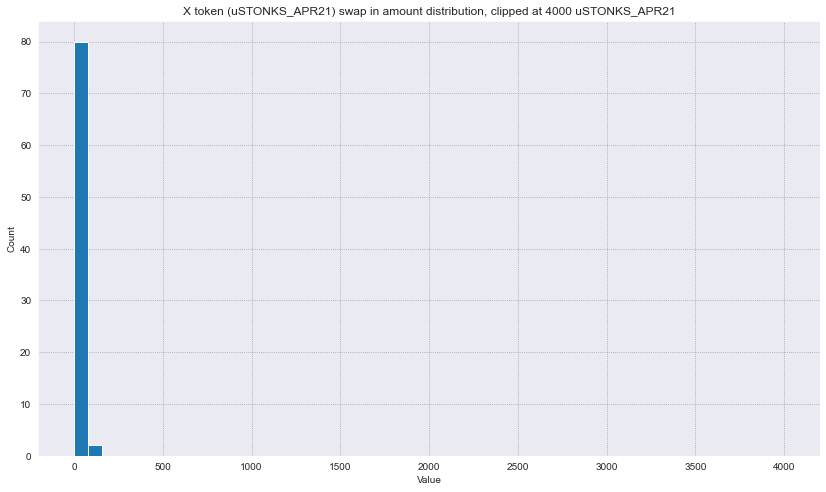

In [52]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

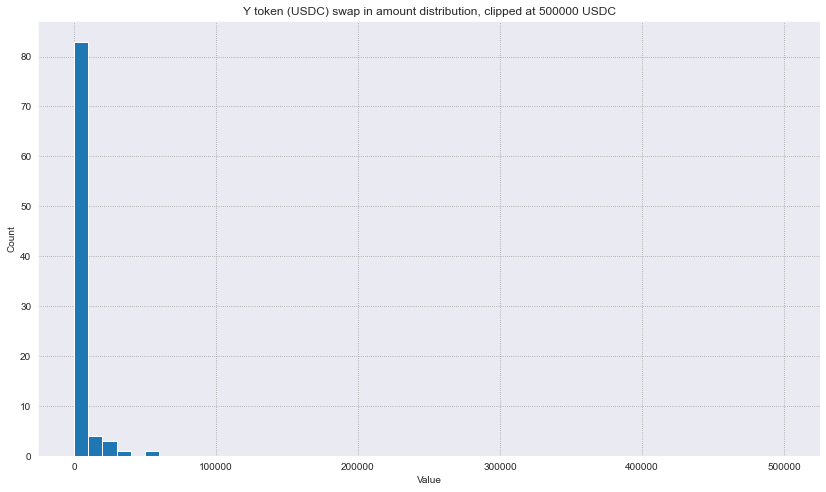

In [53]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

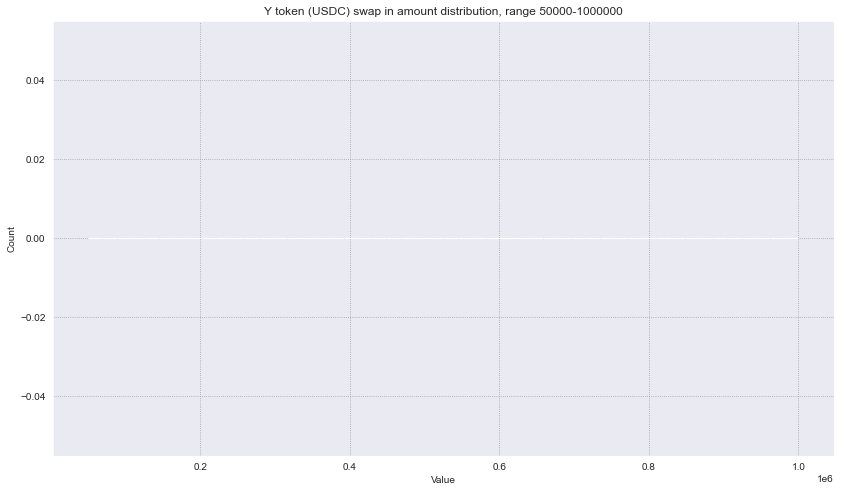

In [54]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

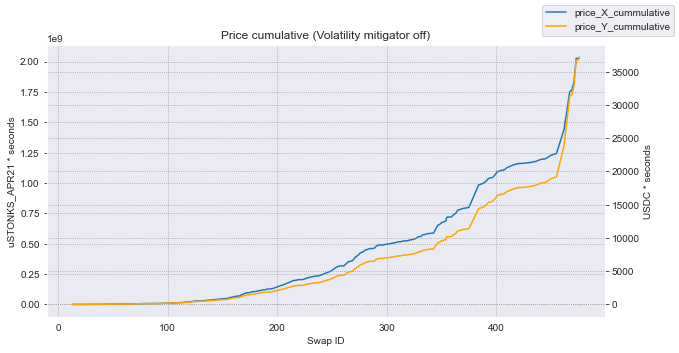

In [55]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

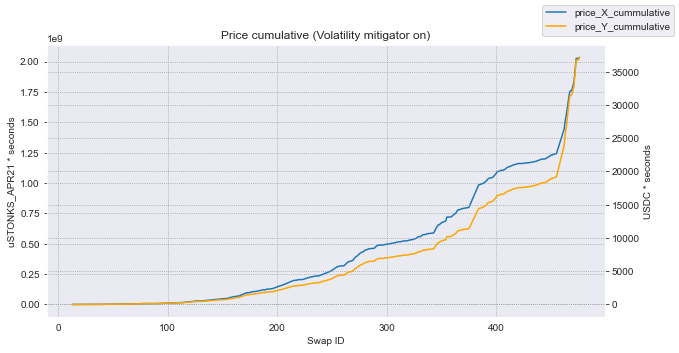

In [56]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

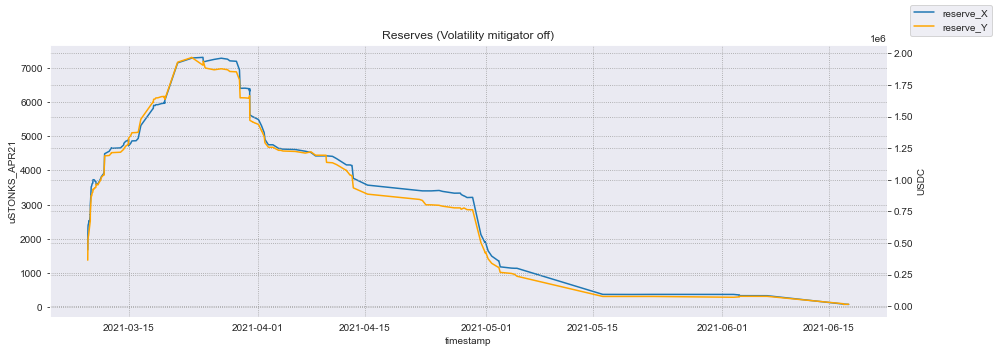

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

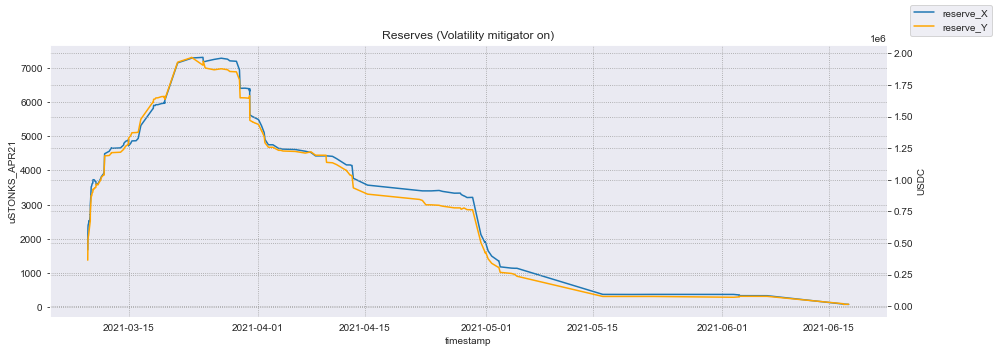

In [58]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

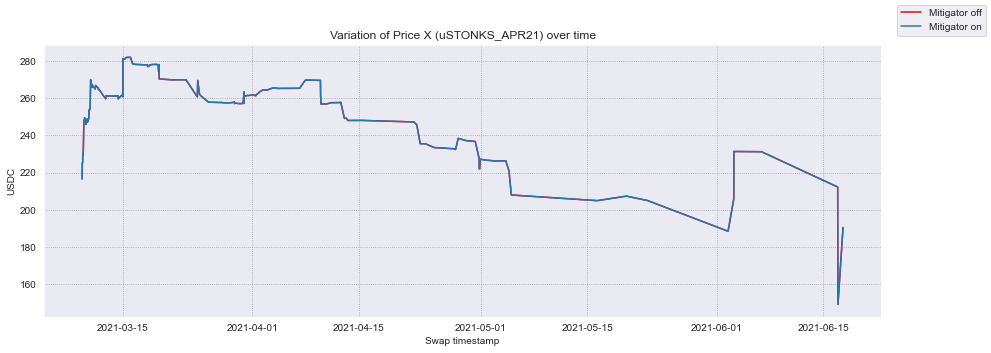

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is the same as in the initial version**

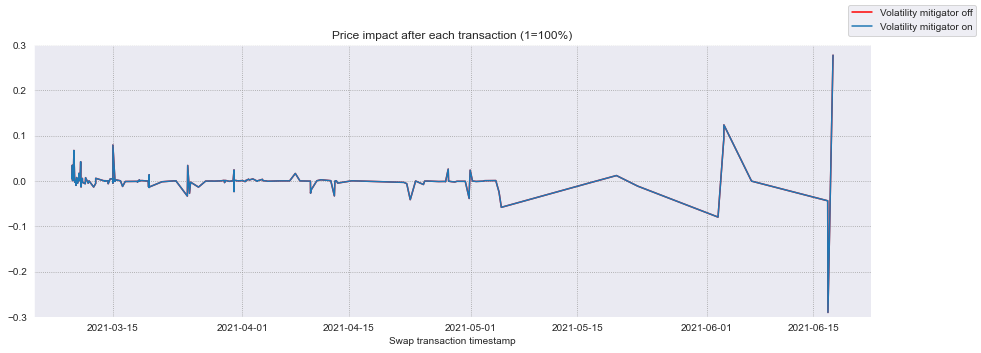

In [60]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The price impact of each swap becomes bigger, as the reserves decrease. As no swaps are blocked, it’s the same with the volatility mitigation mechanism enabled / disabled.**

In [61]:
swaps1_df.iloc[725:750]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff


In [15]:
swaps1_df[swaps1_df.price_diff > 0.25]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
173,476,USDC,uSTONKS_APR21,1757.05474,0.0,10.325864,7.028219,CHECKED,11.62119,11.0,13.0,39.0,SUCCESS,613412.0,2021-06-17 14:21:49,2021-06-17 14:21:41,0xb0dd839a329ed3e0ff8339daacf3a41935ab35cd34b9...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x4481461f5d2cea356855917cd7c213001bbfa087,476,89.83089,13393.332578,1.203135e+06,2025794847,36759,True,79.505025,15143.359099,1.203973e+06,2034393899,37145,True,190.470464,0.277511


In [71]:
#swaps1_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,13,USDC,uSTONKS_APR21,2159.220526,0.0,9.930202,8.636882,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,37571.0,2021-03-09 15:01:34,2021-03-09 15:01:21,0xeaf57e2488fdd6b12b0d01ba29f687f2523efe2f1126...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9670d11c6bdde4d239f699ac71dd77075c35603d,13,1689.373119,3.615258e+05,6.107521e+08,0,0,True,1679.442917,3.636764e+05,6.107738e+08,0,0,True,216.545873,0.011897
1,15,USDC,uSTONKS_APR21,909.722591,0.0,4.149160,3.638890,CHECKED,4.201051,1.0,1.0,1.0,SUCCESS,37578.0,2021-03-09 15:03:19,2021-03-09 15:03:07,0xdaa555d301b25d8dec1d814a1edf263b25ecf703c00e...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x64e78ba4baca646f77a6bf7bcbcc5a31fc066ef2,15,1746.442916,3.781860e+05,6.604802e+08,0,0,True,1742.293756,3.790920e+05,6.604897e+08,22737,0,True,217.582160,0.004783
2,32,USDC,uSTONKS_APR21,8881.277097,0.0,39.726505,35.525108,CHECKED,40.825787,2.0,2.0,2.0,SUCCESS,37729.0,2021-03-09 15:41:04,2021-03-09 15:41:02,0x749f55e09dfd5ec051ad880919f44c9816b708718d18...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd2a78bb82389d30075144d17e782964918999f7f,32,2352.373651,5.118464e+05,1.204054e+09,22737,0,True,2312.647146,5.206921e+05,1.204177e+09,515572,10,True,225.149834,0.034757
3,40,USDC,uSTONKS_APR21,225.978716,0.0,0.993224,0.903915,CHECKED,1.023848,3.0,1.0,1.0,SUCCESS,37846.0,2021-03-09 16:10:19,2021-03-09 16:10:17,0xbec0e4637d4a85ecbae54044c8b49a26929eca1a91d4...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf3239400cd2135cf5f99e191018eeb2a6d01eb76,40,2396.647138,5.396095e+05,1.293254e+09,515572,10,True,2395.653914,5.398346e+05,1.293257e+09,910713,18,True,225.339128,0.000832
4,45,USDC,uSTONKS_APR21,452.519620,0.0,1.986456,1.810078,CHECKED,2.034168,2.0,1.0,1.0,SUCCESS,38016.0,2021-03-09 16:52:49,2021-03-09 16:52:44,0xadf350a8ae7c9576db9f875e88081856085159359245...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9ebc8ad4011c7f559743eb25705ccf5a9b58d0bc,45,2427.201400,5.469452e+05,1.327546e+09,910713,18,True,2425.214943,5.473959e+05,1.327553e+09,1485330,30,True,225.710271,0.001644
5,47,USDC,uSTONKS_APR21,4000.000000,0.0,17.419593,16.000000,CHECKED,17.974567,3.0,1.0,1.0,SUCCESS,38027.0,2021-03-09 16:55:34,2021-03-09 16:55:26,0x730638aab7373a34bdf98c8b75e91e728439eec2ec87...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xa8612c28c8f878ec80f8a6630796820ae8c7690e,47,2445.214942,5.519113e+05,1.349542e+09,1485330,30,True,2427.795350,5.558953e+05,1.349600e+09,1522572,30,True,228.971225,0.014445
6,52,USDC,uSTONKS_APR21,229.830559,0.0,0.993309,0.919322,CHECKED,1.026376,3.0,1.0,1.0,SUCCESS,38156.0,2021-03-09 17:27:49,2021-03-09 17:27:37,0xf998bbbb581e16ef153db9a7b0be95f648cbe83a1afe...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x0b84d1d6c2e2832af66a88a79eaca1fade4f100d,52,2430.879404,5.566017e+05,1.353032e+09,1522572,30,True,2429.886095,5.568306e+05,1.353035e+09,1965632,39,True,229.159129,0.000820
7,64,USDC,uSTONKS_APR21,3000.000000,0.0,12.894451,12.000000,CHECKED,13.290424,3.0,1.0,1.0,SUCCESS,38470.0,2021-03-09 18:46:19,2021-03-09 18:46:12,0x202934d7ba01c3e385de1a9acc9cc33c80992bacf53d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbc904354748f3eaea50f0ea36c959313ff55cc39,64,2540.243371,5.821284e+05,1.478748e+09,1965632,39,True,2527.348920,5.851164e+05,1.478793e+09,3044987,59,True,231.513901,0.010261
8,65,USDC,uSTONKS_APR21,872.883034,0.0,3.727119,3.491532,CHECKED,3.866248,3.0,1.0,1.0,SUCCESS,38477.0,2021-03-09 18:48:04,2021-03-09 18:47:56,0xfafea5fdeae8fa21bb2582e522f55556087a2d1b6522...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf4d